In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numpy import pi
from scipy.optimize import leastsq
from numpy.fft import *
%matplotlib notebook

In [935]:
N=10000;Nc=4;Nf=16;Nb=4;L=int(np.sqrt(Nc))
beta=100;
mu=0;
t=1
n=200
matsubara=(2*np.linspace(0,n,n+1)+1)*np.pi/beta

In [936]:
KX=np.linspace(-pi,pi,L+1);KX=np.delete(KX,0);dK=KX[1]-KX[0];min_K=np.min(KX);max_K=np.max(KX)
KY=np.linspace(-pi,pi,L+1);KY=np.delete(KY,0)
KX,KY=np.meshgrid(KX,KY)

In [937]:
kx=np.linspace(-2*pi,2*pi,2*int(np.sqrt(N))+1);kx=np.delete(kx,0);min_k=np.min(kx);max_k=np.max(kx)
ky=np.linspace(-2*pi,2*pi,2*int(np.sqrt(N))+1);ky=np.delete(ky,0)
kx,ky=np.meshgrid(kx,ky)
E_k=2*t*(np.cos(kx)+np.cos(ky))

In [938]:
G0_K=np.empty((matsubara.size,KX.shape[0],KX.shape[1]),dtype=np.complex128)
E_K=np.empty((KX.shape[0],KX.shape[1]))
for i in xrange(L):
    for j in xrange(L):  
            indexes=((kx>(KX[i,j]-dK/2.))&(kx<(KX[i,j]+dK/2.)))&((ky>(KY[i,j]-dK/2.))&(ky<(KY[i,j]+dK/2.)))
            for k in xrange(matsubara.size):
                G0_K[k,i,j]=Nc*np.sum((1j*matsubara[k]+mu-E_k[indexes])**(-1))/N
            E_K[i,j]=Nc*np.sum(E_k[indexes])/N
        

<IPython.core.display.Javascript object>


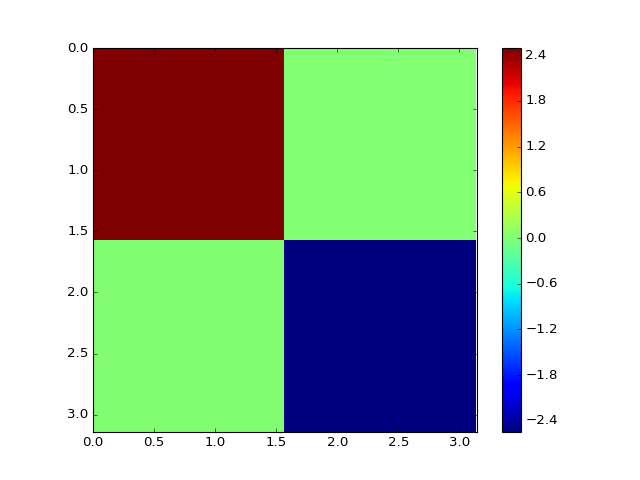

In [939]:
plt.figure()
plt.imshow(E_K,interpolation='None', extent=(min_K,max_K, max_K, min_K))
plt.colorbar()

In [791]:
np.max(E_K)/np.max(E_k)*t

0.62368211269396956

<IPython.core.display.Javascript object>


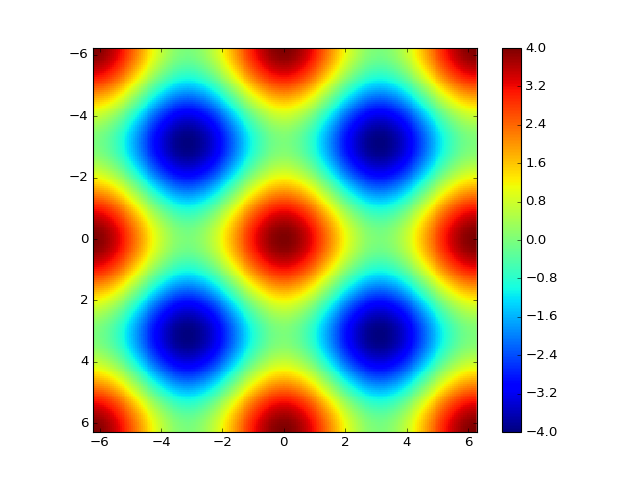

In [940]:
plt.figure()
plt.imshow(E_k,interpolation='None', extent=(min_k,max_k, max_k, min_k))
plt.colorbar()

In [899]:
from scipy.optimize import basinhopping

In [941]:
T=0.5*np.array([[1,1,1,1],[1,-1,-1,1],[1,-1,1,-1],[1,1,-1,-1]])

In [942]:
T

array([[ 0.5,  0.5,  0.5,  0.5],
       [ 0.5, -0.5, -0.5,  0.5],
       [ 0.5, -0.5,  0.5, -0.5],
       [ 0.5,  0.5, -0.5, -0.5]])

In [943]:
G0_R=np.zeros_like(G0_K)
for i in xrange(matsubara.size):
    G0_R[i,:,:]=ifft2(ifftshift(G0_K[i,:,:]))
G0_IJ=np.zeros((matsubara.size,Nc,Nc),dtype=np.complex128)
for i in xrange(Nc):
    for j in xrange(Nc):
        x=i%L-j%L;y=i//L-j//L
        if x<0: x=x+L
        if y<0: y=y+L
        G0_IJ[:,i,j]=G0_R[:,x,y]
G0_M=np.zeros_like(G0_IJ)
for i in xrange(matsubara.size):
    G0_M[i,:,:]=(inv(T).dot(G0_IJ[i,:,:])).dot(T)    
h=np.random.random(Nf);ek=np.random.random(Nf);em=np.random.random(Nc)

In [944]:
def molecular_GF(parameters):
    em=parameters[0];h=parameters[1:Nf/Nc+1];ek=parameters[Nf/Nc+1:]
    G0=np.zeros(matsubara.size,dtype=np.complex128)
    for i in xrange(matsubara.size):
        G0[i]=(1j*matsubara[i]+mu-em-np.sum(h**2/(1j*matsubara[i]-ek)))**(-1)
    return G0

In [945]:
bounds=[]
for i in xrange(1+2*Nf/Nc):
    bounds.append((-4*t,4*t))

parameters=[]
for i in xrange(Nc):
    p_inp=2*np.random.random(1+2*Nf/Nc)-1;G0_real=G0_M[:,i,i]
    def error_hyb_function(parameters):
        G0=molecular_GF(parameters)
        return np.sum(np.abs(np.conj(G0-G0_real)*(G0-G0_real)))
    p_res=fmin_l_bfgs_b(error_hyb_function, x0=p_inp,approx_grad=True,disp=True,bounds=bounds)
    parameters.append(p_res[0])

In [946]:
em=np.zeros((Nc,Nc));h=np.zeros((Nc,Nf));ek=np.zeros(Nf)
for i in xrange(Nc):
    em[i,i]=parameters[i][0]
    h[i,i:(i+Nf/Nc)] =parameters[i][1:Nf/Nc+1]
    ek[i:(i+Nf/Nc)]=parameters[i][Nf/Nc+1:]

In [947]:
em

array([[-2.51814572,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  2.7959423 ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.02520598,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.02529186]])

In [948]:
(inv(T).dot(em)).dot(T)

array([[ 0.0820736 , -1.32850053, -1.32854348,  0.05682469],
       [-1.32850053,  0.0820736 ,  0.05682469, -1.32854348],
       [-1.32854348,  0.05682469,  0.0820736 , -1.32850053],
       [ 0.05682469, -1.32854348, -1.32850053,  0.0820736 ]])

In [949]:
h

array([[ -2.03975249e-01,  -1.90884133e-01,  -2.89858127e-02,
         -7.52173195e-01,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,  -3.53432125e-01,  -6.61523016e-01,
          1.47413551e-04,   1.31094080e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,  -5.24501879e-01,
         -5.12039592e-01,  -1.62750219e-01,  -1.65957344e-01,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.0000

In [950]:
ek

array([-0.24381798,  0.60665872,  0.58234001, -0.56717737,  0.58247476,
       -0.06007331,  0.06125178,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

<IPython.core.display.Javascript object>


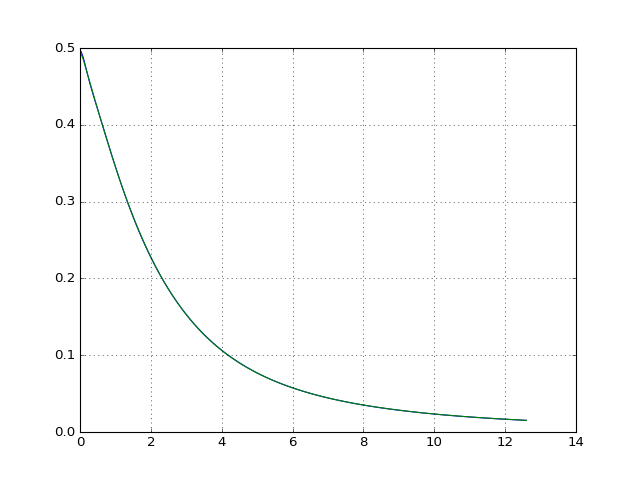

<IPython.core.display.Javascript object>


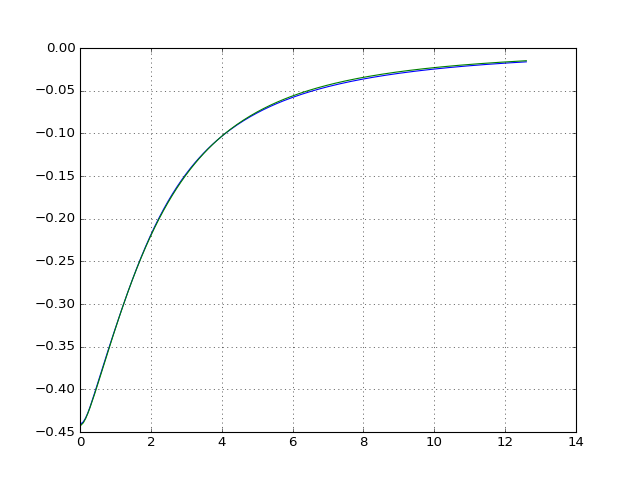

<IPython.core.display.Javascript object>


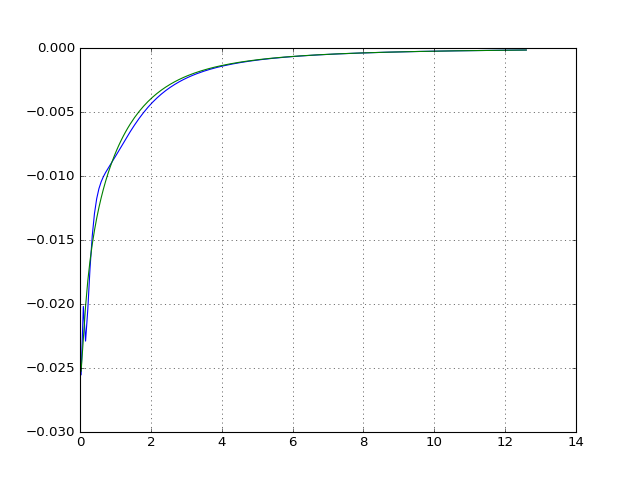

<IPython.core.display.Javascript object>


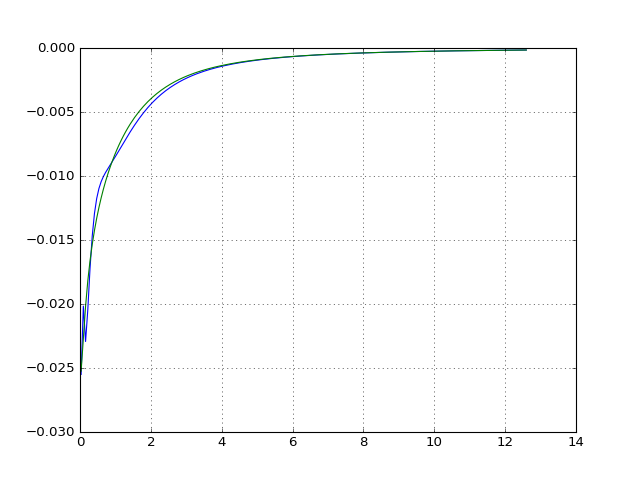

In [951]:
for i in xrange(Nc):
    plt.figure()
    plt.plot(matsubara,molecular_GF(parameters[i]))
    plt.plot(matsubara,G0_M[:,i,i])
    plt.grid()